# Import

In [1]:
import os
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import pytorch_lightning as pl
from torchvision.utils import make_grid
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from argparse import Namespace
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms
import albumentations as albu
from matplotlib import pyplot as plt
from architectures import MulResUnet3D, DiceLoss, Iou_pytorch, lovasz_hinge
from PatchExtractor import PatchExtractor

seed = pl.seed_everything(42)

# Help Function

In [6]:
# helper function for data visualization
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def event2pd(path, epoch=-1):
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 0,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = {}
    runlog_image = {}
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data[tag] = r

    # Dirty catch of DataLossError
    except:
        print("Event file possibly corrupt: {}".format(path))
    return runlog_data

def visual(img, lbl, gen, slice_ind):
    fig = plt.figure(figsize=(18, 12))
    plt.subplot(231)
    plt.imshow(img[:,slice_ind,:].T, cmap='seismic')
    plt.imshow(lbl[:,slice_ind,:].T, cmap='gray', alpha=0.3)
    plt.title('Inline_%d_lbl' % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.subplot(232)
    plt.imshow(img[:,slice_ind,:].T, cmap='seismic')
    plt.imshow(gen[:,slice_ind,:].T, cmap='gray', alpha=0.3)
    plt.title('Inline_%d_prec' % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.subplot(233)
    plt.imshow(gen[:,slice_ind,:].T - lbl[:,slice_ind,:].T, cmap='gray')
    plt.title('Inline_%d_Error' % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.subplot(234)
    plt.imshow(img[slice_ind,:,:].T, cmap='seismic')
    plt.imshow(lbl[slice_ind,:,:].T, cmap='gray', alpha=0.3)
    plt.title('Xline_%d_lbl' % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.subplot(235)
    plt.imshow(img[slice_ind,:,:].T, cmap='seismic')
    plt.imshow(gen[slice_ind,:,:].T, cmap='gray', alpha=0.3)
    plt.title('Xline_%d_prec'  % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.subplot(236)
    plt.imshow(gen[slice_ind,:,:].T - lbl[slice_ind,:,:].T, cmap='gray')
    plt.title('Xline_%d_Error' % slice_ind)
    plt.xlabel('Offset')
    plt.ylabel('Depth')
    plt.show()

# hyperparameter

In [8]:
args = {
    'csv_path': '/nas/home/fkong/data/faultdetect/synthetic_wu/data.csv',
    'results_dir': '/nas/home/fkong/data/faultdetect/synthetic_wu/preds/',
    'results_name': 'multi3d',
    'batch_size': 1,
    'num_threads': 8,
    'lr': 0.001,
    'b1': 0.9,
    'b2': 0.999,
    'max_epochs': 200,
    'port': 8098,
    'display_freq': 100,
    'version':0
}

In [9]:
# net = smp.FPN(encoder_name=args['ENCODER'], 
#         encoder_weights=args['ENCODER_WEIGHTS'], 
#         classes=1, 
#         activation=None)

# Load data

In [79]:
class SimuDataset(Dataset):
    """Dataset for simulated far image datas
    Args:
        csv_path (str): The path of the csv file saved the information of dataset
        phase (str): indicating the train, val, test.
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)
    """
    def __init__(
            self,
            csv_path,
            phase,
            augmentation=None,
    ):
        
        df = pd.read_csv(csv_path, converters={'name': str})
        df_tr = df[df['mode'] == 'train']
        df_val = df[df['mode'] == 'val']
        df_test = df[df['mode'] == 'test']
        
        if phase == 'train':
            self.lbl_paths = df_tr['lbl_path'].values
            self.img_paths = df_tr['img_path'].values
        elif phase == 'val':
            self.lbl_paths = df_val['lbl_path'].values
            self.img_paths = df_val['img_path'].values
        else:
            self.lbl_paths = df_test['lbl_path'].values
            self.img_paths = df_test['img_path'].values
        
        self.augmentation = augmentation

    def __getitem__(self, i):

        # read data
        image = np.load(self.img_paths[i])[np.newaxis]
        mask = np.load(self.lbl_paths[i])[np.newaxis]
        image = (image - image.mean()) / image.std()

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return {'img': torch.from_numpy(image), 
                "lbl": torch.from_numpy(mask),
                'img_name': os.path.basename(self.img_paths[i]),
               'lbl_name':os.path.basename(self.lbl_paths[i])}

    def __len__(self):
        return len(self.img_paths)
    

# augmentation

In [91]:
def augmentation(image, mask):
    ind = np.random.randint(0, 4, size=1)[0]
    image = image.squeeze(0)
    mask = mask.squeeze(0)
    sample = {}
    sample['image'] = np.rot90(image, k=ind, axes=(0,1)).copy()[np.newaxis]
    sample['mask'] = np.rot90(mask, k=ind, axes=(0,1)).copy()[np.newaxis]
    return sample 

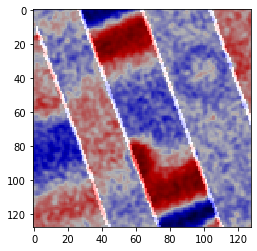

In [95]:
#### Visualize resulted augmented images and masks
img_dir = '/nas/home/fkong/data/faultdetect/synthetic_wu/data.csv'
phase = 'val'
augmented_dataset = SimuDataset(
    img_dir, phase, augmentation=augmentation
)

sample = augmented_dataset[0]
image = sample['img']
mask = sample['lbl']
plt.imshow(image[0,:,:,10].T, cmap='seismic')
plt.imshow(mask[0,:,:,10].T, cmap='gray', alpha=0.3)

# fig, axs = plt.subplots(figsize=(12,12), nrows=2, ncols=2)
# for i, ax in enumerate(axs.flatten()):
#     ax.imshow(image[i,:,:,10].T, cmap='seismic')
#     ax.imshow(mask[i,:,:,10].T, cmap='gray', alpha=0.3)

# network

In [ ]:
preprocessing_fn = get_preprocessing_fn(args['ENCODER'], args['ENCODER_WEIGHTS'])
csv_path = args['csv_path']
train_dataset = SimuDataset(csv_path, 'train',
#                             augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn))
dataloader = DataLoader(train_dataset, shuffle=True,
                      batch_size=32, num_workers=1)
for i, data in enumerate(dataloader):
    img = data['img']
    lbl = data['lbl']
    cara = data['cara']
#     gens = make_grid(torch.sigmoid(y_hat), normalize=True, scale_each=True, padding=10, pad_value=1)
    imgs = make_grid(img, normalize=True, scale_each=True, padding=10, pad_value=1)
    lbls = make_grid(lbl, normalize=True, scale_each=True, padding=10, pad_value=1)
    visualize(image=imgs.numpy().transpose(1,2,0), mask=lbls.numpy().transpose(1,2,0))
    break

# Segmentation

## PL MODEL

In [30]:
class UnetModel(pl.LightningModule):
    def __init__(self, hparams):
        super(UnetModel, self).__init__()

        self.hparams = hparams
        
        self.net = MulResUnet3D(1, 1)
#         self.net = smp.Unet(
#             encoder_name=hparams.ENCODER, 
#             encoder_weights=hparams.ENCODER_WEIGHTS, 
#             classes=1, 
#             activation=None)
    
#         checkpoint_dir = '/nas/home/fkong/data/farimage/simulation/fracture_new/preds/frac_multi/UNET/version_6/'
#         ckpt_name = [x for x in os.listdir(checkpoint_dir) if '.ckpt' in x][0]
#         chp = torch.load(os.path.join(checkpoint_dir, ckpt_name))

#         state_dict = OrderedDict([(k.replace('net.', ''), v) for k, v in chp['state_dict'].items()])
#         self.net.load_state_dict(state_dict)

        self.criterionDice = DiceLoss()  #   DiceLoss_iou()

        self.criterionCE = torch.nn.BCELoss()

        self.criterionlozasz = lovasz_hinge()
        self.iou = Iou_pytorch()
        self.register_buffer("val_acc", torch.zeros(1))
        # self.criterionweightBCE = weightcrossentropyloss()  
    def forward(self, x):
        # called with self(x)
        return self.net(x)

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x = batch['img'].transpose(0, 1)
        y = batch['lbl'].transpose(0, 1)
        y_hat = self(x)
        loss_Dice = self.criterionDice(y_hat, y)

        iou_metric = self.iou(y_hat, y)

        loss_all = loss_Dice
        bar = {'iou': iou_metric}
        tensorboard_logs = {'train_dice': 1 - loss_Dice, 'train_iou':iou_metric}
        return {'loss': loss_all, 'progress_bar':bar, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x = batch['img']
        y = batch['lbl']
        y_hat = self(x)
        loss_Dice = 1 - self.criterionDice(y_hat, y)
        iou_metric = self.iou(y_hat, y)

        tensorboard_logs = {'val_iou': iou_metric, 'val_dice': loss_Dice}
        return {'loss': 1- loss_Dice, 'iou': iou_metric, 'log':tensorboard_logs}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_iou = torch.stack([x['iou'] for x in outputs]).mean()
#         avg_cara = torch.stack([x['cara'] for x in outputs]).mean()
        self.val_acc = avg_iou
        return {'val_loss': avg_loss, 'val_acc':avg_iou}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x = batch['img']
        y = batch['lbl']
        y_hat= self(x)
        loss_Dice = 1 - self.criterionDice(y_hat, y)
        iou_metric = self.iou(y_hat, y)
        print('the iou of %s is %f' % (batch['img_name'], iou_metric.item()))
       
        bar = {'test_iou': iou_metric}
        logs = {'test_iou': iou_metric, 'test_dice':loss_Dice}
        return {'iou': iou_metric.item(), 'dice':loss_Dice.item(), 
                'progress_bar':bar, 'log':logs, 'gen':y_hat.sigmoid().cpu().numpy()}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        save_dir = os.path.join(self.hparams.results_dir, self.hparams.results_name, 'version_' + str(self.hparams.version))
        out_dict = {}
        for i, x in enumerate(outputs):
            out_dict['gen_%d' % i] = x['gen'].squeeze()
            out_dict['iou_%d' % i] = x['iou']
        
        avg_iou = np.array([x['iou'] for x in outputs]).mean()
        avg_dice = np.array([x['dice'] for x in outputs]).mean()
        out_dict['avg_iou'] = avg_iou
        out_dict['avg_dice'] = avg_dice
        np.save(os.path.join(save_dir, 'res.npy'), out_dict)
        return {'test_iou': avg_iou, 'test_dice':avg_dice}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        self.logger.log_hyperparams(self.hparams)
        
#         optimizer = torch.optim.SGD(self.net.parameters(), lr=self.hparams.lr, momentum=0.9)

        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.hparams.lr,
                                     betas=(self.hparams.b1, self.hparams.b2))
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.2, threshold=1e-4, patience=3, eps=0.001),
                        'interval': 'epoch',
                        'monitor': 'val_acc'}
#         lr_scheduler = {'scheduler': torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.01),
#                         'interval': 'batch'}
#         lr_scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5),
#                         'interval': 'epoch'}
        return [optimizer], [lr_scheduler]

    def train_dataloader(self):
        # REQUIRED
        train_dataset = SimuDataset(self.hparams.csv_path, 'train', 
                                    augmentation=False)
        return DataLoader(train_dataset, shuffle=True,
                          batch_size=self.hparams.batch_size, num_workers=int(self.hparams.num_threads)) 

    def val_dataloader(self):
        # OPTIONAL
        val_dataset = SimuDataset(self.hparams.csv_path, 'val')
        return DataLoader(val_dataset, shuffle=False,
                          batch_size=self.hparams.batch_size, num_workers=int(self.hparams.num_threads))

    def test_dataloader(self):
        # OPTIONAL
        test_data = SimuDataset(self.hparams.csv_path, 'test')
        return DataLoader(test_data, shuffle=False,
                          batch_size=1, num_workers=int(self.hparams.num_threads))


## PL Train

In [31]:
hyparams = Namespace(**args)

segmodel = UnetModel(hyparams)

earlystop = pl.callbacks.EarlyStopping('val_acc', mode='max', min_delta=1e-4, patience=10)
tb_logger = pl.loggers.TensorBoardLogger(hyparams.results_dir, hyparams.results_name, version=hyparams.version)
checkpoint_callback = pl.callbacks.ModelCheckpoint(os.path.join(tb_logger.log_dir,
                                                   'version_' + str(tb_logger.version)), monitor='val_acc',
                                                  verbose=True)
lr_logger = pl.callbacks.lr_logger.LearningRateLogger()
cmd = 'tensorboard --logdir %s --port %s' % (tb_logger.log_dir, hyparams.port)
print(cmd)

gpus = [0, 1, 2, 3]

trainer = pl.Trainer(early_stop_callback=earlystop, gpus=gpus, distributed_backend='dp', 
                    logger=tb_logger, max_epochs=hyparams.max_epochs, min_epochs=50,
                    callbacks=[lr_logger],
                    checkpoint_callback=checkpoint_callback)
trainer.fit(segmodel)

trainer = pl.Trainer(gpus=[0])

checkpoint_dir = os.path.join(tb_logger.log_dir)
ckpt_name = [x for x in os.listdir(checkpoint_dir) if '.ckpt' in x][0]


segmodel = UnetModel.load_from_checkpoint(
    os.path.join(checkpoint_dir, ckpt_name),
    map_location=None)

trainer.test(segmodel)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


tensorboard --logdir /nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_0 --port 8098


the iou of ['0.npy'] is 0.614563
the iou of ['1.npy'] is 0.790590
the iou of ['2.npy'] is 0.818780
the iou of ['3.npy'] is 0.769999
the iou of ['4.npy'] is 0.681902
the iou of ['5.npy'] is 0.713745
the iou of ['6.npy'] is 0.622434
the iou of ['7.npy'] is 0.715975
the iou of ['8.npy'] is 0.693114
the iou of ['9.npy'] is 0.686907
the iou of ['10.npy'] is 0.800404
the iou of ['11.npy'] is 0.735435
the iou of ['12.npy'] is 0.682196
the iou of ['13.npy'] is 0.501851
the iou of ['14.npy'] is 0.670530
the iou of ['15.npy'] is 0.645518
the iou of ['16.npy'] is 0.648277
the iou of ['17.npy'] is 0.685228
the iou of ['18.npy'] is 0.619303
the iou of ['19.npy'] is 0.625404
--------------------------------------------------------------------------------
TEST RESULTS
{'test_dice': 0.8101095348596573, 'test_iou': 0.6861078113317489}
--------------------------------------------------------------------------------



## result on test dataset

### The First try, multires3dnetwork, batchnormalization,single gpu, without data augmentation, dice loss

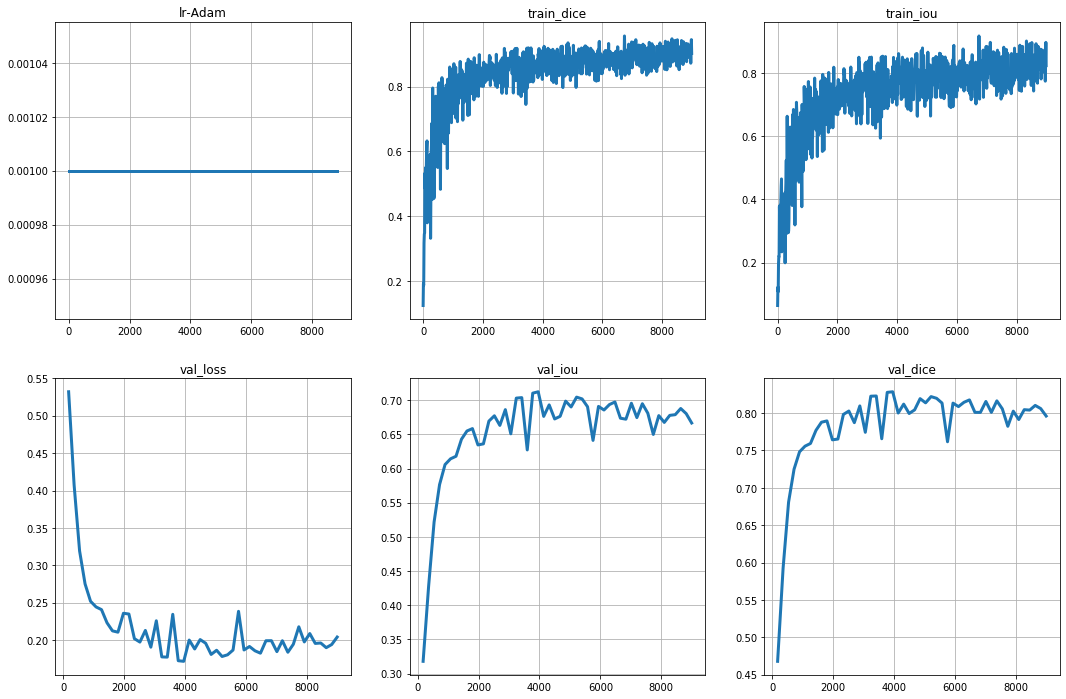

In [17]:
event_dir = '/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_0'
event_names = [s for s in os.listdir(event_dir) if 'events' in s]
event_path = os.path.join(event_dir, event_names[0])

dfs = event2pd(event_path)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))
axs = axs.flatten()
i = 0
for key, value in dfs.items():
    if key != 'epoch':
        if 'test' in key:
            axs[i].scatter(value['step'], value['value'])
            axs[i].set_ylim(0, 1)
            axs[i].set_xlim(value['step'].values[0]-100, value['step'].values[0]+100)
            axs[i].text(value['step'], value['value']-0.1, '%.3f' % value['value'].values[0])
            axs[i].set_title(key)
            axs[i].grid()
        else:
            axs[i].plot(value['step'], value['value'], linewidth=3)
            axs[i].set_title(key)
            axs[i].grid(which = 'both')
        
        i += 1

print('the iou is %f, dice is %f on the test dataset')

In [17]:
df = pd.read_csv('/nas/home/fkong/data/faultdetect/synthetic_wu/metric_compare.csv')
arr = [gens['iou_%d' % i] for i in range(20)]
df['munet-bn-dice'] = arr
df

,Filename,WU,VNet(CE+Dice),VNet-Modified,UNet-DS (TTAd,UNet-Res1(CE),Unet-Res2,Unet-Res2(TTA),UNet-Res1-KD,munet-bn-dice
0,0,0.695,0.672,0.711,0.800,0.764,0.801,0.814,0.812,0.614563
1,1,0.701,0.721,0.761,0.824,0.751,0.809,0.824,0.796,0.790590
2,2,0.774,0.672,0.810,0.851,0.822,0.864,0.861,0.837,0.818780
3,3,0.686,0.672,0.737,0.787,0.738,0.787,0.801,0.786,0.769999
4,4,0.623,0.672,0.630,0.691,0.661,0.686,0.699,0.676,0.681902
5,5,0.611,0.672,0.675,0.715,0.693,0.714,0.721,0.719,0.713745
6,6,0.651,0.672,0.730,0.794,0.750,0.789,0.786,0.782,0.622434
7,7,0.631,0.672,0.702,0.754,0.723,0.750,0.749,0.757,0.715975
8,8,0.698,0.672,0.731,0.756,0.744,0.761,0.758,0.763,0.693114
9,9,0.598,0.672,0.669,0.659,0.649,0.691,0.693,0.695,0.686907


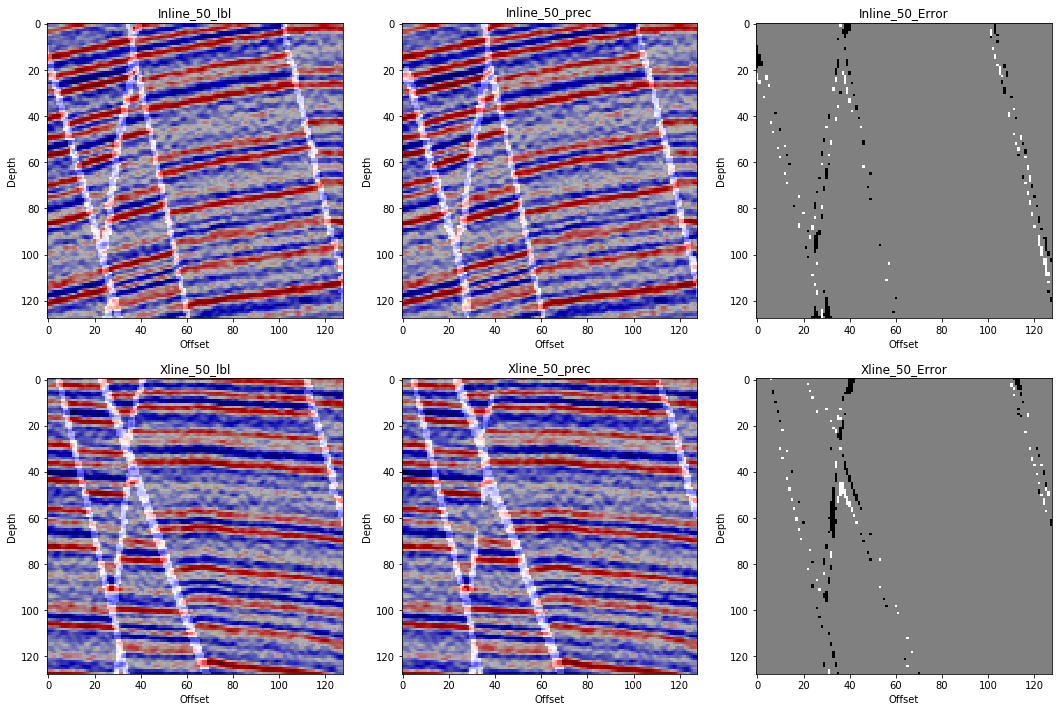

In [7]:
gens = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_0/res.npy', allow_pickle=True).item()
ind = 1
img = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/validation/seis/%d.npy' % ind)
lbl = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/validation/fault/%d.npy' % ind)
gen = gens['gen_%d' % ind].squeeze().round()
visual(img, lbl, gen, 50)

### multi-res-unet, IN, 4-gpu, BCE-loss

the iou is %f, dice is %f on the test dataset


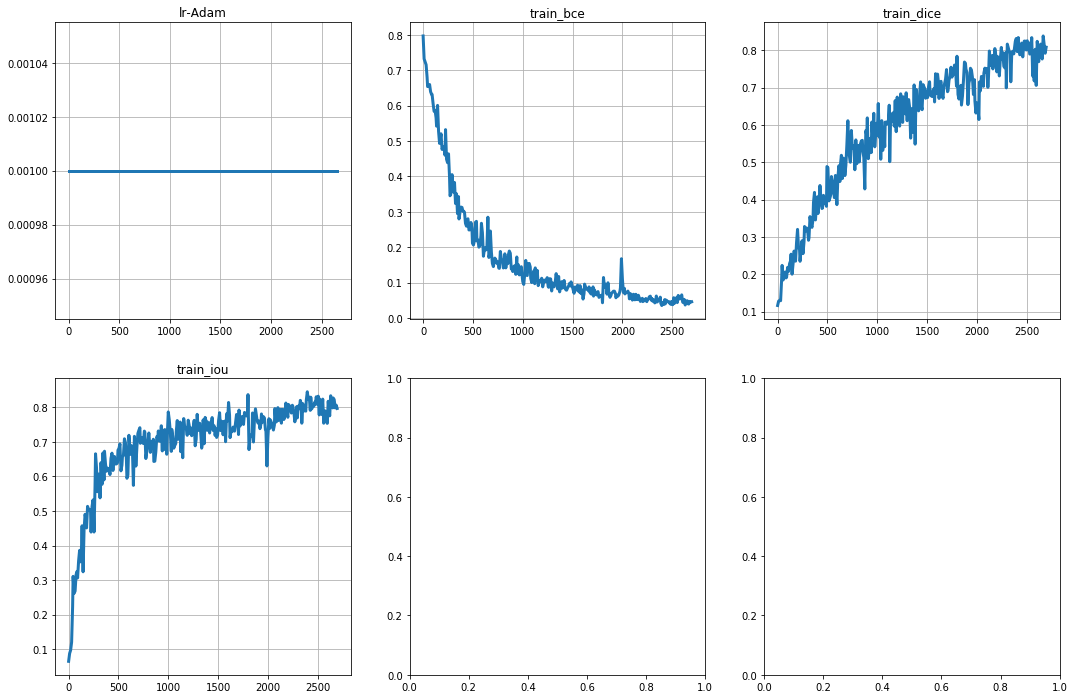

In [18]:
event_dir = '/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_3'
event_names = [s for s in os.listdir(event_dir) if 'events' in s]
event_path = os.path.join(event_dir, event_names[0])

dfs = event2pd(event_path)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))
axs = axs.flatten()
i = 0
for key, value in dfs.items():
    if key != 'epoch':
        if 'test' in key:
            axs[i].scatter(value['step'], value['value'])
            axs[i].set_ylim(0, 1)
            axs[i].set_xlim(value['step'].values[0]-100, value['step'].values[0]+100)
            axs[i].text(value['step'], value['value']-0.1, '%.3f' % value['value'].values[0])
            axs[i].set_title(key)
            axs[i].grid()
        else:
            axs[i].plot(value['step'], value['value'], linewidth=3)
            axs[i].set_title(key)
            axs[i].grid(which = 'both')
        
        i += 1

In [20]:
df = pd.read_csv('/nas/home/fkong/data/faultdetect/synthetic_wu/metric_compare.csv')
gens = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_3/res.npy', allow_pickle=True).item()
arr = [gens['iou_%d' % i] for i in range(20)]
df['munet-In-bce'] = arr
df

,Filename,WU,VNet(CE+Dice),VNet-Modified,UNet-DS (TTAd,UNet-Res1(CE),Unet-Res2,Unet-Res2(TTA),UNet-Res1-KD,munet-In-bce
0,0,0.695,0.672,0.711,0.800,0.764,0.801,0.814,0.812,0.793873
1,1,0.701,0.721,0.761,0.824,0.751,0.809,0.824,0.796,0.809605
2,2,0.774,0.672,0.810,0.851,0.822,0.864,0.861,0.837,0.842616
3,3,0.686,0.672,0.737,0.787,0.738,0.787,0.801,0.786,0.793160
4,4,0.623,0.672,0.630,0.691,0.661,0.686,0.699,0.676,0.676235
5,5,0.611,0.672,0.675,0.715,0.693,0.714,0.721,0.719,0.708975
6,6,0.651,0.672,0.730,0.794,0.750,0.789,0.786,0.782,0.785875
7,7,0.631,0.672,0.702,0.754,0.723,0.750,0.749,0.757,0.739192
8,8,0.698,0.672,0.731,0.756,0.744,0.761,0.758,0.763,0.765115
9,9,0.598,0.672,0.669,0.659,0.649,0.691,0.693,0.695,0.693529


In [21]:
print(df.mean())

Filename          9.500000
WU                0.634800
VNet(CE+Dice)     0.644950
VNet-Modified     0.684450
UNet-DS (TTAd     0.743450
UNet-Res1(CE)     0.700300
Unet-Res2         0.736350
Unet-Res2(TTA)    0.746800
UNet-Res1-KD      0.743500
munet-In-bce      0.741945
dtype: float64


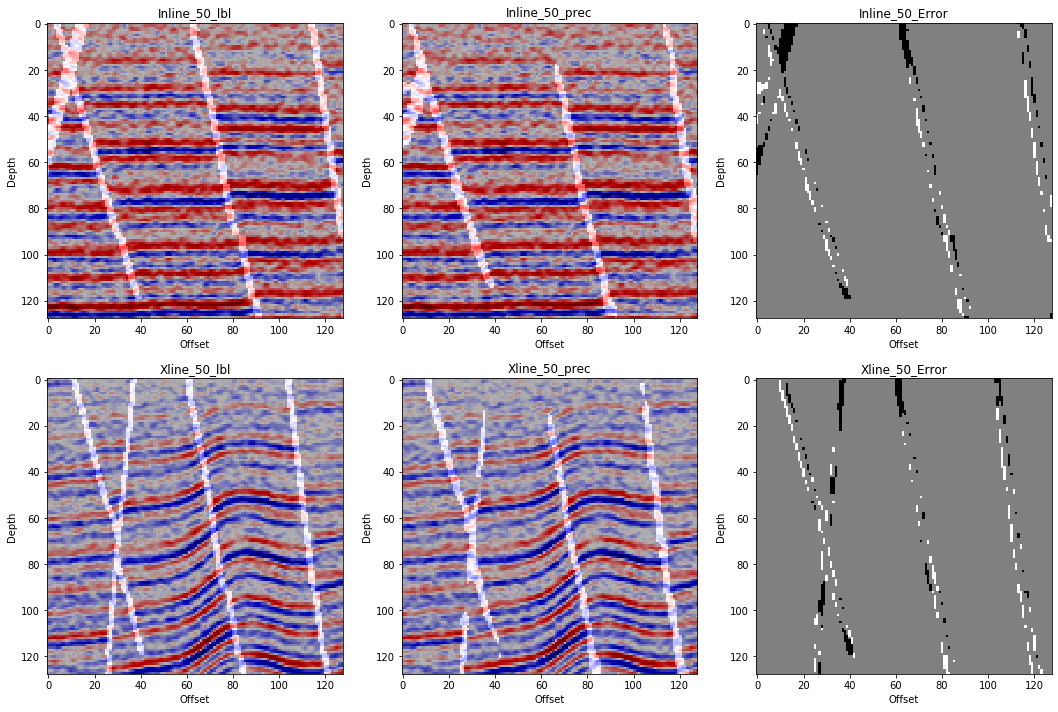

In [9]:
file_ind = 15
img = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/validation/seis/%d.npy' % file_ind)
lbl = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/validation/fault/%d.npy' % file_ind)
gen = gens['gen_%d' % file_ind].squeeze().round()
slice_ind = 50
visual(img, lbl, gen, slice_ind)

### multi-res-unet, IN, 4-gpu, BCE-loss, with attention

attention u-net

In [12]:
df = pd.read_csv('/nas/home/fkong/data/faultdetect/synthetic_wu/metric_compare.csv')
gens = np.load('/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_4/res.npy', allow_pickle=True).item()
arr = [gens['iou_%d' % i] for i in range(20)]
df['munet-In-bce-att'] = arr
df

,Filename,WU,VNet(CE+Dice),VNet-Modified,UNet-DS (TTAd,UNet-Res1(CE),Unet-Res2,Unet-Res2(TTA),UNet-Res1-KD,munet-In-bce-att
0,0,0.695,0.672,0.711,0.800,0.764,0.801,0.814,0.812,0.795356
1,1,0.701,0.721,0.761,0.824,0.751,0.809,0.824,0.796,0.819156
2,2,0.774,0.672,0.810,0.851,0.822,0.864,0.861,0.837,0.845926
3,3,0.686,0.672,0.737,0.787,0.738,0.787,0.801,0.786,0.806553
4,4,0.623,0.672,0.630,0.691,0.661,0.686,0.699,0.676,0.698766
5,5,0.611,0.672,0.675,0.715,0.693,0.714,0.721,0.719,0.716862
6,6,0.651,0.672,0.730,0.794,0.750,0.789,0.786,0.782,0.779148
7,7,0.631,0.672,0.702,0.754,0.723,0.750,0.749,0.757,0.755376
8,8,0.698,0.672,0.731,0.756,0.744,0.761,0.758,0.763,0.773937
9,9,0.598,0.672,0.669,0.659,0.649,0.691,0.693,0.695,0.692668


In [11]:
df.mean()

Filename          9.500000
WU                0.634800
VNet(CE+Dice)     0.644950
VNet-Modified     0.684450
UNet-DS (TTAd     0.743450
UNet-Res1(CE)     0.700300
Unet-Res2         0.736350
Unet-Res2(TTA)    0.746800
UNet-Res1-KD      0.743500
munet-In-bce      0.747643
dtype: float64

# Test on the field dataset

In [13]:
from GPUtil import getFirstAvailable, getGPUs
from scipy import io
from termcolor import colored
dtype = torch.cuda.FloatTensor

def set_gpu(id=-1):
    """
    Set GPU device or select the one with the lowest memory usage (None for
    CPU-only)
    """
    if id is None:
        # CPU only
        print(colored('GPU not selected', 'yellow'))
    else:
        # -1 for automatic choice
        device = id if id is not -1 else getFirstAvailable(order='memory')[0]
        try:
            name = getGPUs()[device].name
        except IndexError:
            print('The selected GPU does not exist. Switching to the most '
                  'available one.')
            device = getFirstAvailable(order='memory')[0]
            name = getGPUs()[device].name

        print(colored('GPU selected: %d - %s' % (device, name), 'yellow'))
        os.environ["CUDA_VISIBLE_DEVICES"] = str(device)


In [14]:
set_gpu(5)

checkpoint_dir = '/nas/home/fkong/data/faultdetect/synthetic_wu/preds/multi3d/version_3'

ckpt_name = [x for x in os.listdir(checkpoint_dir) if '.ckpt' in x][0]

net = MulResUnet3D(1, 1).type(dtype)
# net = ShrinkageNet(1,1).type(dtype)
chp = torch.load(os.path.join(checkpoint_dir, ckpt_name))

state_dict = OrderedDict([(k.replace('net.', ''), v) for k, v in chp['state_dict'].items()])
net.load_state_dict(state_dict)
net.eval()

data = np.load('/nas/home/fkong/data/faultdetect/ichthys/patch.npy', allow_pickle=True).item()
data = data['data']

pe = PatchExtractor((128, 128, 128), stride=(128, 128, 128))
patches = pe.extract(data)
ori_shape = patches.shape
patches = patches.reshape((-1, 128, 128, 128))
precs = []

for patch in patches:
    patch = torch.from_numpy(patch[np.newaxis, np.newaxis]).type(dtype)
    patch = (patch - patch.mean()) / patch.std()

    prec = net(patch)

    prec = prec.sigmoid().round().int().detach().cpu().numpy().squeeze()
    precs.append(prec)
precs = np.array(precs)
precs = pe.reconstruct(precs.reshape(ori_shape))

GPU selected: 5 - TITAN V


<Figure size 1296x864 with 0 Axes>

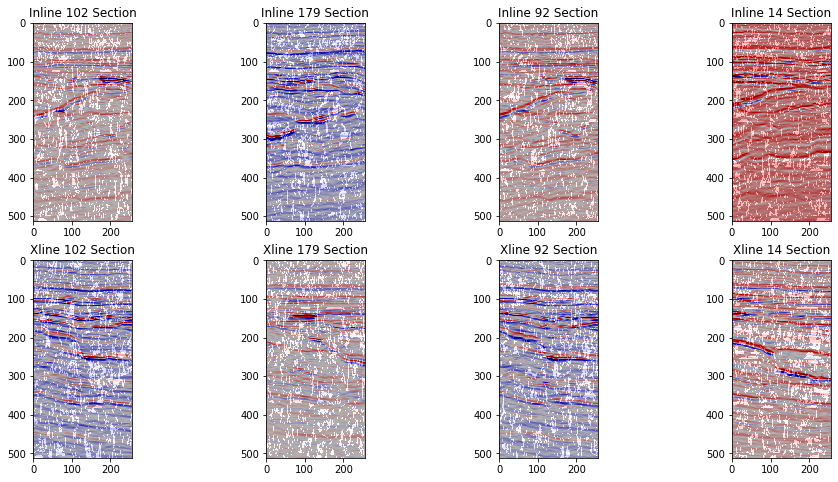

In [15]:
indexs = np.random.randint(0, 256, size=4)
fig = plt.figure(figsize=(18, 12))
fig, axs = plt.subplots(nrows=2, ncols=len(indexs), figsize=(4 * len(indexs), 8))
for i in range(len(indexs)):
    axs[0, i].imshow(data[:,indexs[i],:].T, cmap='seismic')
    axs[0, i].imshow(precs[:,indexs[i],:].T, cmap='gray', alpha=0.3)
    axs[0,i].set_title('Inline %d Section' % indexs[i])
    
    axs[1, i].imshow(data[indexs[i], :,:].T, cmap='seismic')
    axs[1, i].imshow(precs[indexs[i], :,:].T, cmap='gray', alpha=0.3)
    axs[1,i].set_title('Xline %d Section' % indexs[i])    

In [32]:
data = np.load('/nas/home/fkong/data/faultdetect/ichthys/seismic.npy')
patch = data[1000:1256, 500:756,300:812]
res = {}
res['data'] = patch
res['range'] = [1000, 1256, 500, 756, 300, 812]
np.save('/nas/home/fkong/data/faultdetect/ichthys/patch.npy', res)